# Triton Puzzle 5: Fused Cross Entropy Loss

Welcome to the fifth Triton puzzle! Cross entropy loss is fundamental to classification tasks. This puzzle is special because it introduces **PyTorch autograd integration**. That means you'll implement both forward and backward passes!

### What you'll learn:

- **Fusing multiple operations** for efficiency (log-softmax + nll_loss)
- **PyTorch autograd integration** using `torch.autograd.Function`
- **Backward pass implementation** for gradient computation
- **Numerical stability** at extreme values
- **Memory efficiency** by avoiding intermediate tensors
- **Interoperability** between Triton kernels and PyTorch's autograd



## Mathematical Background

**Cross-entropy loss** for a single example with logits $\mathbf{x}\in\mathbb{R}^C$ and ground-truth class label $y\in\{0,\dots,C-1\}$ is

$$
\mathcal L(\mathbf{x},y)
\;=\;
-\log\frac{e^{x_{y}}}{\sum_{j=0}^{C-1} e^{x_{j}}}
\;=\;
-\;x_{y} + \log\left(\sum_{j=0}^{C-1} e^{x_{j}}\right).
$$

> **Implementation Note**: The form $-x_y + \log(\sum_j e^{x_j})$ is key for numerical stability. In the Triton kernel, we compute the log-sum-exp term using the max trick: $\max(\mathbf{x}) + \log(\sum_j e^{x_j - \max(\mathbf{x})})$.

For a mini-batch of $N$ examples, we stack examples as rows: $X\in\mathbb{R}^{N\times C}$ with labels $\mathbf{y}\in\{0,\dots,C-1\}^N$. With **mean reduction**:

$$
\boxed{\;
\mathcal L(X,\mathbf{y})=\frac{1}{N}\sum_{n=0}^{N-1}
\mathcal L\left(\mathbf{x}^{(n)},y_n\right)
\;}
$$

where $\mathbf{x}^{(n)}$ denotes the $n$-th row of $X$ (logits for the $n$-th example).

> **Memory Efficiency**: Our Triton kernel computes this loss without ever materializing the $N \times C$ softmax probability matrix!

---

### Step-by-Step Gradient Derivation (single example)

The gradient computation is crucial for backpropagation and reveals why this operation fuses so beautifully:

1. **Softmax probabilities**
   $$
   p_i
   =\operatorname{softmax}(\mathbf{x})_i
   =\frac{e^{x_i}}{\sum_{j=0}^{C-1}e^{x_j}}.
   $$

2. **Derivative of the log-sum-exp term**
   $$
   \frac{\partial}{\partial x_i}
   \log\left(\sum_{j}e^{x_j}\right)
   =\frac{e^{x_i}}{\sum_{j}e^{x_j}}
   =p_i.
   $$
   
   > **Key insight**: The gradient requires the softmax probabilities $p_i$, which we can recompute in the backward pass rather than storing them!

3. **Combine pieces**
   $$
   \frac{\partial\mathcal L}{\partial x_i}
   =\frac{\partial}{\partial x_i}
     \left[-x_y+\log\left(\sum_{j}e^{x_j}\right)\right]
   =-\,\delta_{iy}+p_i
   =\begin{cases}
        p_i-1,& i=y,\\[6pt]
        p_i,& i\neq y.
     \end{cases}
   $$
   
   where $\delta_{iy} = 1$ if $i = y$, else $0$ (Kronecker delta).

4. **Vector form**
   Let $\mathbf{y}^{\text{onehot}}\in\{0,1\}^C$ with $(\mathbf{y}^{\text{onehot}})_i=\delta_{iy}$. Then:
   
   $$
   \boxed{\;
   \nabla_{\mathbf{x}}\mathcal L
   =\mathbf{p}-\mathbf{y}^{\text{onehot}}
   \;}
   $$
   
   <!-- > **Triton Implementation**: In the backward kernel, we compute this as: -->
   <!-- > ```python -->
   <!-- > softmax = tl.exp(logits - max_logit) / sum_exp -->
   <!-- > grad = softmax - tl.where(offs == label, 1.0, 0.0) -->
   <!-- > ``` -->

---

### Extension to a Mini-Batch with Chain Rule

For a batch, define:
- $P = \operatorname{softmax}(X)$ (row-wise softmax)
- $Y \in \{0,1\}^{N\times C}$ (one-hot encoding of labels)

For **mean reduction** loss with upstream gradient $\mathbf{g} \in \mathbb{R}^N$:

$$
\boxed{\;
\frac{\partial \mathcal{L}_{\text{total}}}{\partial X_{ij}}
= \frac{1}{N} \cdot g_i \cdot (P_{ij} - Y_{ij})
\;}
$$

> **Chain Rule in Practice**: The $g_i$ term (grad_output in PyTorch) scales each example's gradient.
<!-- > In our Triton kernel: -->
<!-- > ```python -->
<!-- > grad = (softmax - one_hot) * grad_output[row] -->
<!-- > ``` -->

---

### Numerical Stability: The Log-Sum-Exp Trick

Direct computation of $\log(\sum_j e^{x_j})$ can overflow. Instead, we use:

$$
\log\left(\sum_{j} e^{x_j}\right) = \max(\mathbf{x}) + \log \left(\sum_{j} e^{x_j - \max(\mathbf{x})}\right)
$$

This is more numerically stable.

<!-- > **Triton Code Alignment**: -->
<!-- > ```python -->
<!-- > # First pass: find max -->
<!-- > max_logit = tl.max(chunk) -->
<!-- > # Second pass: compute stable log-sum-exp   -->
<!-- > exp_chunk = tl.exp(chunk - max_logit) -->
<!-- > sum_exp += tl.sum(exp_chunk) -->
<!-- > log_sum_exp = max_logit + tl.log(sum_exp) -->
<!-- > ``` -->

---

### Why Fuse? Memory and Computation Analysis

**Unfused approach** (naive):
1. Compute softmax → store $N \times C$ tensor
2. Take log → store $N \times C$ tensor  
3. Select correct class → store $N$ tensor
4. Negate → final loss

**Memory traffic**: $3NC + N$ elements

**Fused approach** (our implementation):
- Single pass through input
- Only store final loss ($N$ elements)
- Recompute softmax in backward pass

**Memory traffic**: $NC + N$ elements (forward), $NC + NC$ elements (backward)

> **Performance Impact**: For typical values (N=1024, C=50000), fusion reduces memory traffic by ~3x, which directly translates to faster execution on memory-bound GPUs!

In [1]:
import torch
import triton
import triton.language as tl
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt

DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')
print(f"Using device: {DEVICE}")

# Set random seed
torch.manual_seed(42)

Using device: cuda:0


## Implementation 1: Naive PyTorch (Unfused)

First, let's see the unfused approach:

In [2]:
def cross_entropy_naive(logits, labels):
    """
    Naive unfused implementation.
    This creates multiple intermediate tensors.
    """
    # Step 1: Compute softmax
    softmax = torch.softmax(logits, dim=-1)
    
    # Step 2: Take log
    log_softmax = torch.log(softmax)
    
    # Step 3: Gather correct class and negate
    batch_size = logits.shape[0]
    losses = -log_softmax[torch.arange(batch_size), labels]
    
    return losses

## Implementation 2: PyTorch Built-in

PyTorch's built-in is already optimized and fused:

In [3]:
def cross_entropy_pytorch(logits, labels, reduction='none'):
    """PyTorch's built-in cross entropy."""
    return torch.nn.functional.cross_entropy(logits, labels, reduction=reduction)

## Implementation 3: PyTorch Compiled

In [4]:
@torch.compile
def cross_entropy_compiled(logits, labels):
    """
    Naive unfused implementation.
    This creates multiple intermediate tensors.
    """
    # Step 1: Compute softmax
    softmax = torch.softmax(logits, dim=-1)
    
    # Step 2: Take log
    log_softmax = torch.log(softmax)
    
    # Step 3: Gather correct class and negate
    batch_size = logits.shape[0]
    losses = -log_softmax[torch.arange(batch_size), labels]
    
    return losses

## Key Concepts for This Puzzle

### 1. PyTorch Autograd Integration

To integrate with PyTorch's autograd:

```python
class CustomFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, *args, **kwargs):
        # Save tensors needed for backward
        ctx.save_for_backward(input, *args, **kwargs)
        # Compute forward pass
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve saved tensors
        input, extras = ctx.saved_tensors
        # Compute gradients
        return grad_input, *extras
```

### 2. Numerical Stability

Use the log-sum-exp trick:
- Instead of: `log(sum(exp(x)))`
- Compute: `max(x) + log(sum(exp(x - max(x))))`

### 3. Memory Considerations

- Forward: Only save what's needed for backward (logits and labels)
- Backward: Compute softmax again rather than storing it
- This trades computation for memory

## Implementation 4: Triton Kernels (Puzzle)

Now implement both forward and backward kernels!

In [8]:
@triton.jit
def cross_entropy_forward_kernel(
    logits_ptr, labels_ptr, losses_ptr,
    N, C,
    BLOCK_SIZE: tl.constexpr
):
    """
    Forward kernel for cross entropy loss.
    Each program handles one sample.
    
    Steps:
    1. Load all logits for this sample
    2. Compute max for numerical stability
    3. Compute log-sum-exp
    4. Compute loss = log-sum-exp - logit[label]
    """
    # YOUR IMPLEMENTATION GOES HERE
    # Hints:
    # 1. Use tl.program_id(0) to get sample index
    # 2. Load all C logits for this sample (loop if C > BLOCK_SIZE)
    # 3. Find max using tl.max
    # 4. Compute stable log-sum-exp
    # 5. Load the label and compute final loss
    pass


@triton.jit
def cross_entropy_backward_kernel(
    grad_output_ptr, logits_ptr, labels_ptr, grad_input_ptr,
    N, C,
    BLOCK_SIZE: tl.constexpr
):
    """
    Backward kernel for cross entropy loss.
    Each program handles one sample.
    
    Gradient formula: softmax(logits) - one_hot(label)
    Scaled by grad_output (chain rule)
    """
    # YOUR IMPLEMENTATION GOES HERE
    # Hints:
    # 1. Recompute softmax (don't store it from forward!)
    # 2. Subtract 1 from the softmax value at the label position
    # 3. Multiply by grad_output for chain rule
    pass

### PyTorch Function Integration

In [9]:
class FusedCrossEntropyFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, logits, labels):
        """
        Forward pass of fused cross entropy.
        
        Args:
            logits: (N, C) tensor of logits
            labels: (N,) tensor of class indices
            
        Returns:
            losses: (N,) tensor of losses
        """
        assert logits.is_contiguous()
        assert labels.is_contiguous()
        assert labels.dtype == torch.long
        
        N, C = logits.shape
        
        # Allocate output
        losses = torch.empty(N, device=logits.device, dtype=logits.dtype)
        
        # Choose block size
        BLOCK_SIZE = triton.next_power_of_2(min(C, 1024))
        
        # Launch forward kernel
        grid = (N,)
        cross_entropy_forward_kernel[grid](
            logits, labels, losses,
            N, C,
            BLOCK_SIZE
        )
        
        # Save for backward
        ctx.save_for_backward(logits, labels)
        
        return losses
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass of fused cross entropy.
        
        Args:
            grad_output: (N,) gradient w.r.t. losses
            
        Returns:
            grad_logits: (N, C) gradient w.r.t. logits
            grad_labels: None (labels don't need gradients)
        """
        logits, labels = ctx.saved_tensors
        N, C = logits.shape
        
        # Allocate gradient
        grad_logits = torch.empty_like(logits)
        
        # Choose block size
        BLOCK_SIZE = triton.next_power_of_2(min(C, 1024))
        
        # Launch backward kernel
        grid = (N,)
        cross_entropy_backward_kernel[grid](
            grad_output, logits, labels, grad_logits,
            N, C,
            BLOCK_SIZE
        )
        
        return grad_logits, None

# Convenience function
def cross_entropy_triton(logits, labels):
    """Fused cross entropy loss using Triton."""
    return FusedCrossEntropyFunction.apply(logits, labels)

## Solution (🧙 You shall not pass!)

Here is a simple solution:

In [38]:
@triton.jit
def cross_entropy_forward_kernel(
    logits_ptr, labels_ptr, losses_ptr,
    N, C,
    BLOCK_SIZE: tl.constexpr
):
    """Forward kernel for cross entropy loss."""
    # Program ID = sample index
    row = tl.program_id(0)
    
    # Base pointers
    logits_row_ptr = logits_ptr + row * C
    
    # First pass: find max for numerical stability
    max_logit = -float('inf')
    for start_idx in range(0, C, BLOCK_SIZE):
        offs = start_idx + tl.arange(0, BLOCK_SIZE)
        mask = offs < C
        
        # Load chunk of logits
        chunk = tl.load(logits_row_ptr + offs, mask=mask, other=-float('inf'))
        
        # Update max
        max_logit = tl.max(tl.maximum(chunk, max_logit))
    
    # Second pass: compute log-sum-exp
    sum_exp = 0.0
    for start_idx in range(0, C, BLOCK_SIZE):
        offs = start_idx + tl.arange(0, BLOCK_SIZE)
        mask = offs < C
        
        # Load chunk and compute exp
        chunk = tl.load(logits_row_ptr + offs, mask=mask, other=-float('inf'))
        exp_chunk = tl.exp(chunk - max_logit)
        
        # Accumulate sum
        sum_exp += tl.sum(tl.where(mask, exp_chunk, 0.0))
    
    # Compute log-sum-exp
    log_sum_exp = max_logit + tl.log(sum_exp)
    
    # Get the label for this sample
    label = tl.load(labels_ptr + row)
    
    # Get the logit for the correct class
    correct_logit = tl.load(logits_row_ptr + label)
    
    # Compute loss
    loss = log_sum_exp - correct_logit
    
    # Store result
    tl.store(losses_ptr + row, loss)

@triton.jit
def cross_entropy_backward_kernel(
    grad_output_ptr, logits_ptr, labels_ptr, grad_input_ptr,
    N, C,
    BLOCK_SIZE: tl.constexpr
):
    """Backward kernel for cross entropy loss."""
    # Program ID = sample index
    row = tl.program_id(0)
    
    # Load gradient w.r.t. loss
    grad_out = tl.load(grad_output_ptr + row)
    
    # Base pointers
    logits_row_ptr = logits_ptr + row * C
    grad_row_ptr = grad_input_ptr + row * C
    
    # Load label
    label = tl.load(labels_ptr + row)
    
    # First pass: find max for numerical stability
    max_logit = -float('inf')
    for start_idx in range(0, C, BLOCK_SIZE):
        offs = start_idx + tl.arange(0, BLOCK_SIZE)
        mask = offs < C
        
        chunk = tl.load(logits_row_ptr + offs, mask=mask, other=-float('inf'))
        max_logit = tl.max(tl.maximum(chunk, max_logit))
    
    # Second pass: compute sum of exp
    sum_exp = 0.0
    for start_idx in range(0, C, BLOCK_SIZE):
        offs = start_idx + tl.arange(0, BLOCK_SIZE)
        mask = offs < C
        
        chunk = tl.load(logits_row_ptr + offs, mask=mask, other=-float('inf'))
        exp_chunk = tl.exp(chunk - max_logit)
        sum_exp += tl.sum(tl.where(mask, exp_chunk, 0.0))

    # Third pass: compute gradients
    for start_idx in range(0, C, BLOCK_SIZE):
        offs = start_idx + tl.arange(0, BLOCK_SIZE)
        mask = offs < C
        
        # Load logits and compute softmax
        logits = tl.load(logits_row_ptr + offs, mask=mask, other=-float('inf'))
        softmax = tl.exp(logits - max_logit) / sum_exp
        
        # Compute gradient: softmax - 1(if label) 
        # Check if any offset equals the label
        # is_label = (offs == label)
        # grad = softmax - tl.where(is_label, 1.0, 0.0)

        one_hot = tl.zeros_like(softmax)
        one_hot = tl.where(offs == label, 1.0, 0.0)
        grad = softmax - one_hot
        
        # Scale by upstream gradient
        grad_new = grad * grad_out

        if row == 15 and start_idx == 0:  # First block of first row
            tl.device_print("softmax[0:4]=", softmax)
            tl.device_print("one_hot[0:4]=", one_hot)
            tl.device_print("grad[0:4]=", grad)
        
        # Store
        tl.store(grad_row_ptr + offs, grad_new, mask=mask)


## Testing Correctness

Let's test both forward and backward passes:

In [39]:
def test_forward_pass(N=32, C=100, atol=1e-5, rtol=1e-5):
    """Test forward pass against PyTorch."""
    torch.manual_seed(42)
    
    # Create test data
    logits = torch.randn(N, C, device=DEVICE, requires_grad=True)
    labels = torch.randint(0, C, (N,), device=DEVICE)
    
    # PyTorch reference
    expected = cross_entropy_pytorch(logits, labels, reduction='none')
    
    # Triton implementation
    actual = cross_entropy_triton(logits, labels)
    
    # Check correctness
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"✅ Forward pass PASSED!")
        print(f"   Shape: ({N}, {C})")
        print(f"   Max error: {(actual - expected).abs().max().item():.2e}")
        return True
    except AssertionError as e:
        print(f"❌ Forward pass FAILED!")
        print(f"   Error: {e}")
        return False

def test_backward_pass(N=16, C=50, atol=1e-4, rtol=1e-4):
    """Test backward pass using gradcheck."""
    torch.manual_seed(42)
    
    # Create test data
    logits = torch.randn(N, C, device=DEVICE, dtype=torch.float32, requires_grad=True)
    labels = torch.randint(0, C, (N,), device=DEVICE)
    print(labels)
    
    # Use gradcheck to verify gradients
    try:
        # Also compare against PyTorch
        logits_torch = logits.detach().clone().requires_grad_(True)
        logits_triton = logits.detach().clone().requires_grad_(True)
        
        # Forward
        loss_torch = cross_entropy_pytorch(logits_torch, labels, reduction='none').sum()
        loss_triton = cross_entropy_triton(logits_triton, labels).sum()
        
        # Backward
        loss_torch.backward()
        loss_triton.backward()
        
        # Compare gradients
        torch.testing.assert_close(logits_triton.grad, logits_torch.grad, atol=atol, rtol=rtol)
        print(f"✅ Gradient comparison PASSED!")
        print(f"   Max gradient error: {(logits_triton.grad - logits_torch.grad).abs().max().item():.2e}")
        
        return True
        
    except Exception as e:
        print(f"❌ Backward pass FAILED!")
        print(f"   Error: {e}")
        return False

# Run tests
forward_passed = test_forward_pass()
backward_passed = test_backward_pass()
test_passed = forward_passed and backward_passed

# Display congrats message
if test_passed:
    print("\n🎉 Congratulations! Your implementation is correct!")
    display(Image("https://c.tenor.com/9d2wq28eb9UAAAAC/tenor.gif", width=256, height=256))

✅ Forward pass PASSED!
   Shape: (32, 100)
   Max error: 4.77e-07
tensor([ 3, 19,  0, 24, 12, 43, 20, 32, 17, 40, 35, 18, 15,  2, 37, 36],
       device='cuda:0')
pid (15, 0, 0) idx ( 0) softmax[0:4]=: 0.001600
pid (15, 0, 0) idx ( 1) softmax[0:4]=: 0.003810
pid (15, 0, 0) idx ( 2) softmax[0:4]=: 0.085711
pid (15, 0, 0) idx ( 3) softmax[0:4]=: 0.009921
pid (15, 0, 0) idx ( 4) softmax[0:4]=: 0.003227
pid (15, 0, 0) idx ( 5) softmax[0:4]=: 0.005198
pid (15, 0, 0) idx ( 6) softmax[0:4]=: 0.046027
pid (15, 0, 0) idx ( 7) softmax[0:4]=: 0.018022
pid (15, 0, 0) idx ( 8) softmax[0:4]=: 0.013941
pid (15, 0, 0) idx ( 9) softmax[0:4]=: 0.017213
pid (15, 0, 0) idx (10) softmax[0:4]=: 0.004648
pid (15, 0, 0) idx (11) softmax[0:4]=: 0.004265
pid (15, 0, 0) idx (12) softmax[0:4]=: 0.003289
pid (15, 0, 0) idx (13) softmax[0:4]=: 0.025460
pid (15, 0, 0) idx (14) softmax[0:4]=: 0.007341
pid (15, 0, 0) idx (15) softmax[0:4]=: 0.004852
pid (15, 0, 0) idx (16) softmax[0:4]=: 0.021303
pid (15, 0, 0) idx (1

## Performance Analysis

In [40]:
def analyze_cross_entropy(N, C):
    """Analyze memory and compute for cross entropy."""
    element_size = 4  # float32
    
    # Unfused approach
    unfused = {
        'softmax_store': N * C * element_size,      # Store softmax
        'log_softmax_store': N * C * element_size,  # Store log_softmax
        'memory_traffic': 3 * N * C * element_size,  # Read logits + 2 intermediate writes
    }
    
    # Fused approach
    fused = {
        'memory_traffic': N * C * element_size + N * element_size,  # Read logits + write losses
    }
    
    # Compute
    flops_per_sample = C + C + 1  # exp + sum + log (simplified)
    total_flops = N * flops_per_sample
    
    return {
        'unfused_memory': unfused['memory_traffic'],
        'fused_memory': fused['memory_traffic'],
        'memory_reduction': unfused['memory_traffic'] / fused['memory_traffic'],
        'flops': total_flops,
        'ai_fused': total_flops / fused['memory_traffic']
    }

# Example
N, C = 1024, 1000
analysis = analyze_cross_entropy(N, C)
print(f"Cross Entropy {N}x{C}:")
print(f"  Unfused memory: {analysis['unfused_memory'] / 1e6:.2f} MB")
print(f"  Fused memory: {analysis['fused_memory'] / 1e6:.2f} MB")
print(f"  Memory reduction: {analysis['memory_reduction']:.1f}x")
print(f"  Arithmetic intensity: {analysis['ai_fused']:.2f} FLOPs/byte")

Cross Entropy 1024x1000:
  Unfused memory: 12.29 MB
  Fused memory: 4.10 MB
  Memory reduction: 3.0x
  Arithmetic intensity: 0.50 FLOPs/byte


## Benchmarking

Running benchmarks...


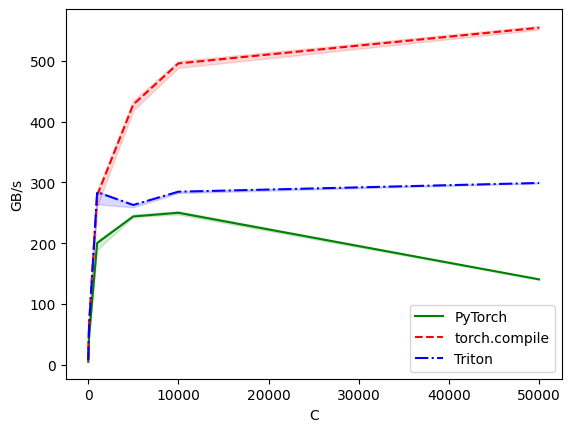

cross-entropy-performance:
         C     PyTorch  torch.compile      Triton
0     10.0    4.541935       7.257732    7.779006
1    100.0   44.733566      67.333331   62.153847
2   1000.0  200.200005     278.539124  284.097561
3   5000.0  243.951224     428.179271  262.886251
4  10000.0  250.025006     495.981384  284.725993
5  50000.0  140.362918     554.772074  299.106340


In [43]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['C'],  # Number of classes
        x_vals=[10, 100, 1000, 5000, 10000, 50000],
        line_arg='provider',
        line_vals=['pytorch', 'compile', 'triton'],
        line_names=['PyTorch', 'torch.compile', 'Triton'],
        styles=[('green', '-'), ('red', '--'), ('blue', '-.')],
        ylabel='GB/s',
        plot_name='cross-entropy-performance',
        args={'N': 1024},
    )
)
def benchmark(C, N, provider):
    """Benchmark cross entropy implementations."""
    logits = torch.randn(N, C, device=DEVICE, dtype=torch.float32)
    labels = torch.randint(0, C, (N,), device=DEVICE)
    
    quantiles = [0.5, 0.05, 0.95]
    
    if provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: cross_entropy_pytorch(logits, labels), quantiles=quantiles
        )
    elif provider == 'compile':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: cross_entropy_compiled(logits, labels), quantiles=quantiles
        )
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: cross_entropy_triton(logits, labels), quantiles=quantiles
        )
    
    # Calculate bandwidth (input + output)
    bytes_moved = logits.numel() * logits.element_size()  # Read logits
    bytes_moved += N * 4  # Write losses
    
    gb_per_s = lambda ms: bytes_moved / ms / 1e6
    
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)

print("Running benchmarks...")
results = benchmark.run(show_plots=True, print_data=True, return_df=True, save_path='')

## Speedup?


🚀 Awesome! Triton is 1.36x faster than PyTorch!


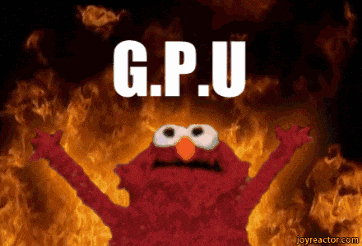

In [44]:
# Check if Triton is faster than PyTorch
avg_pytorch = results['PyTorch'].mean()
avg_triton = results['Triton'].mean()
speedup = avg_triton / avg_pytorch

if speedup > 1.0:
    print(f"\n🚀 Awesome! Triton is {speedup:.2f}x faster than PyTorch!")
    display(Image("https://c.tenor.com/QFFzqAIAvnIAAAAd/tenor.gif", width=400, height=256))
else:
    print(f"\n🐌🐌🐌 Triton implementation is {speedup:.2f}x slower than PyTorch!. 🐌🐌🐌")

## Summary

You've successfully implemented a fused cross entropy loss with full autograd support!

### Key Concepts Mastered:

1. **Operation Fusion**: Combining log-softmax + NLL for efficiency
2. **PyTorch Integration**: Using `torch.autograd.Function`
3. **Gradient Computation**: Efficient backward pass implementation
4. **Numerical Stability**: Log-sum-exp trick for large values
5. **Memory Efficiency**: Avoiding intermediate tensor storage

### Performance Insights:

- **3x memory reduction** by avoiding intermediate tensors
- **Single-pass computation** for both forward and backward
- **Bandwidth-bound operation** benefits greatly from fusion
- **Production-ready** with proper autograd support

### What's Next?

You're ready for the final challenge: Flash Attention!

<img src="sardine-flash.png" width="800" />